In [1]:
import findspark
findspark.init()
from pyspark import SQLContext, SparkContext
from pyspark.sql import functions as F
import json
import numpy as np

from pyspark_dist_explore import hist
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
sc = SparkContext()
sqlContext = SQLContext(sc)

We load the data from the json file. The data is a small subset containing only items from the following categories:
"Baby", "Automotive" and "Grocery and Gourmet Food".

In [3]:
df = sqlContext.read.json("reviews_auto_baby_grocery.json")

We get the count of review of distinc article per reviewer and filter those that have less than 5 review.

In [4]:
df_count = df.groupBy("reviewerID").agg(F.countDistinct("asin").alias('count')).filter("`count` >= 5")

We get all reviews of reviewers with more than 5 articles.

In [5]:
df_filtered = df.join(df_count, on='reviewerID').drop('count')

We compute the average grade for each reviewer.

In [6]:
average_score = df_filtered.groupBy("reviewerID").avg("overall").select("avg(overall)")

In [7]:
average_std_score = df_filtered.groupBy("reviewerID").agg(F.avg("overall").alias("mean"), F.stddev("overall").alias("std"))
average_std_score.cache().count()

109193

In [8]:
average_std_score.select("mean", "std").describe().show()

+-------+------------------+------------------+
|summary|              mean|               std|
+-------+------------------+------------------+
|  count|            109193|            109193|
|   mean|4.2834718157516365|0.9022456674075624|
| stddev|0.6049040387948184|0.5699621176391938|
|    min|               1.0|               0.0|
|    max|               5.0|2.1908902300206647|
+-------+------------------+------------------+



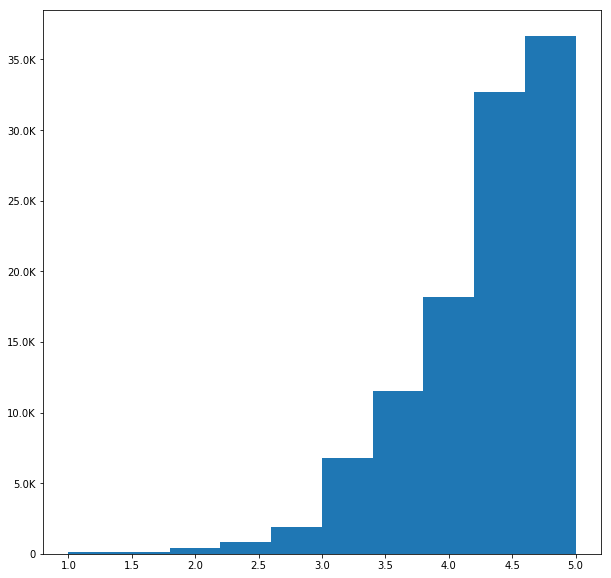

In [9]:
fig, ax = plt.subplots()
fig.set_size_inches(10, 10)
hist(ax, average_std_score.select("mean"));

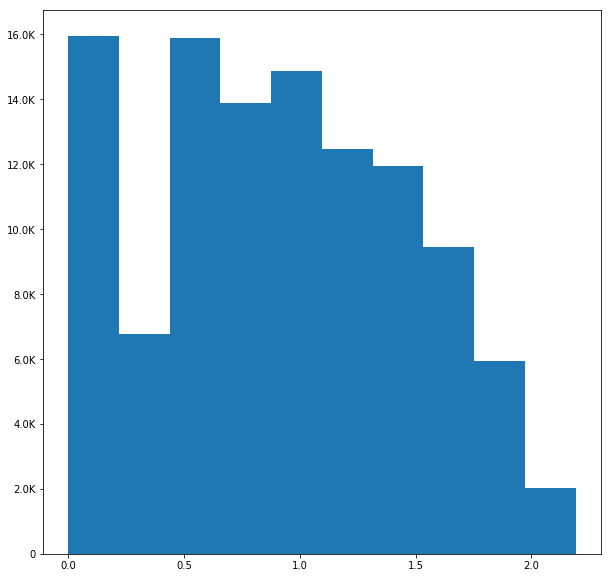

In [10]:
fig, ax = plt.subplots()
fig.set_size_inches(10, 10)
hist(ax, average_std_score.select("std"));

Here, we look at the mean of the ratings given by reviewer with small (<0.25) standard deviation.
We also look at what percentage of reviewer they correspond.

There is 14.72% of reviewer with std < 0.25


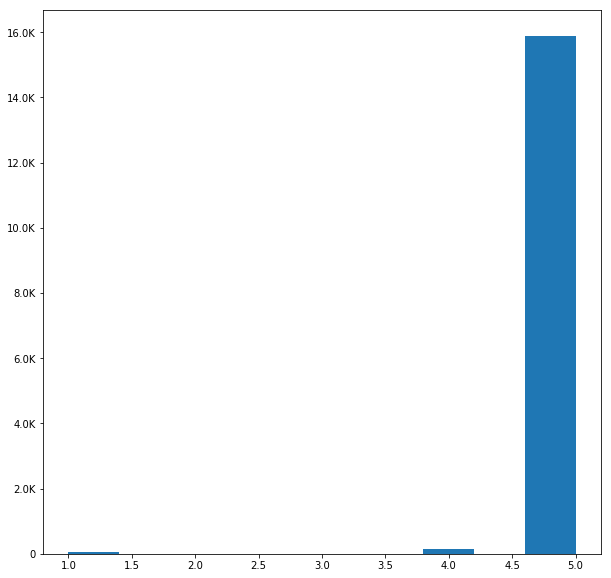

In [11]:
print("There is %.2f%% of reviewer with std < 0.25"%(average_std_score.filter(average_std_score.std < 0.25).count()/average_std_score.count()*100))
fig, ax = plt.subplots()
fig.set_size_inches(10, 10)
hist(ax, average_std_score.filter(average_std_score.std < 0.25).select("mean"));